# Disease Progression Modeling with MultiStateNN

This notebook demonstrates how to use MultiStateNN to model disease progression through multiple states. We'll use synthetic data to model a disease that can progress through four states:

0. Healthy
1. Mild disease
2. Moderate disease
3. Severe disease (absorbing state)

We'll predict transition probabilities between these states based on patient characteristics.

## Setup

First, let's import the necessary packages and set up our environment.

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Import MultiStateNN package
from multistate_nn import fit, ModelConfig, TrainConfig
# Import the visualization and simulation functions from consolidated module
from multistate_nn.utils import (
    plot_transition_heatmap, 
    plot_transition_graph,
    generate_synthetic_data
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Generate Synthetic Disease Progression Data

Let's create a synthetic dataset representing patient transitions between disease states over time.

In [2]:
# Define our state transition structure
# State 0: Healthy -> can progress to Mild (1) or Moderate (2)
# State 1: Mild -> can progress to Moderate (2) or Severe (3)
# State 2: Moderate -> can only progress to Severe (3) 
# State 3: Severe -> absorbing state (no further progression)
state_transitions = {
    0: [1, 2],    # From Healthy, can become Mild or Moderate
    1: [2, 3],    # From Mild, can become Moderate or Severe
    2: [3],       # From Moderate, can only become Severe
    3: []         # Severe is an absorbing state
}

In [3]:
# Generate synthetic data with 3 covariates:
# - age: Patient age
# - biomarker: Disease biomarker level
# - treatment: Treatment indicator (0 or 1)
df = generate_synthetic_data(
    n_samples=1000,
    n_covariates=3,
    n_states=4,
    n_time_points=5,
    state_transitions=state_transitions,
    random_seed=42
)

# Rename the generic covariates to meaningful names
df = df.rename(columns={
    'covariate_0': 'age',
    'covariate_1': 'biomarker',
    'covariate_2': 'treatment'
})

# Rescale age to be more realistic (mean 65, std 10)
df['age'] = 65 + 10 * df['age']

# Make treatment binary
df['treatment'] = (df['treatment'] > 0).astype(int)

# Display the first few rows
df.head()

,time,from_state,to_state,age,biomarker,treatment
0,0,0,1,69.967142,-0.138264,1
1,1,1,3,69.967142,-0.138264,1
2,0,0,2,80.230299,-0.234153,0
3,1,2,3,80.230299,-0.234153,0
4,0,0,2,80.792128,0.767435,0


## Explore the Dataset

Let's examine the distribution of the covariates and transitions in our dataset.

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


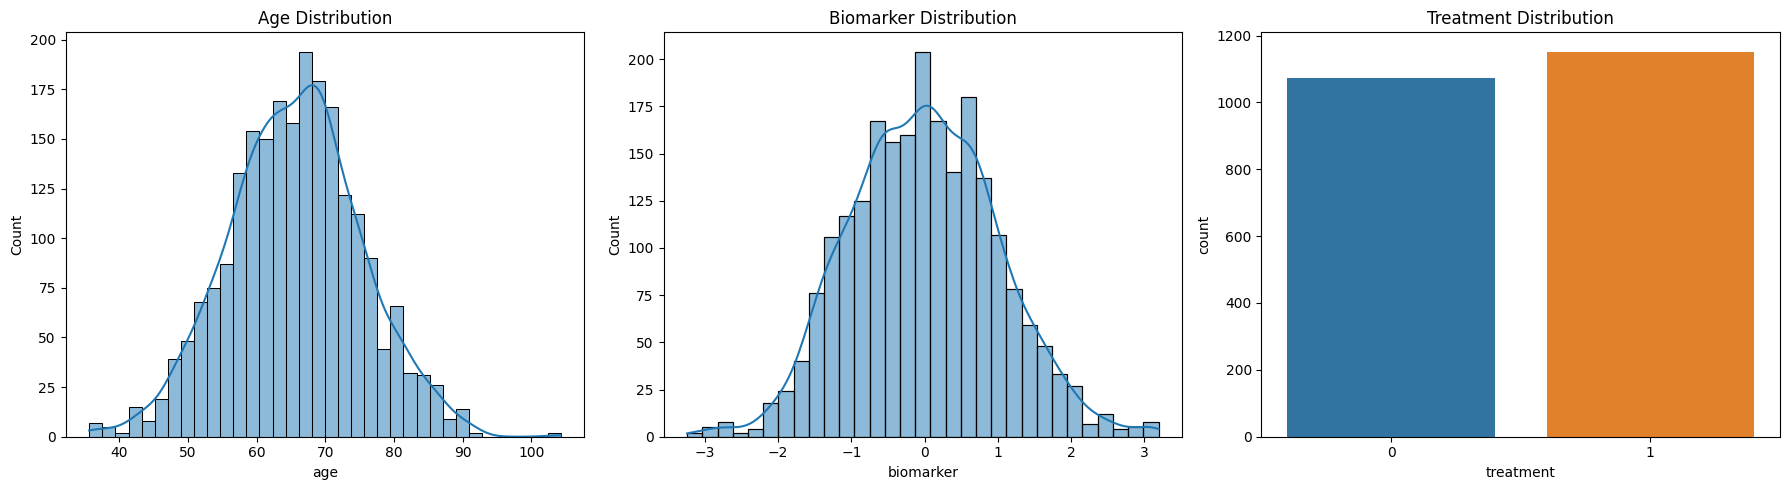

In [4]:
# Visualize covariate distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

sns.histplot(df['biomarker'], kde=True, ax=axes[1])
axes[1].set_title('Biomarker Distribution')

sns.countplot(x='treatment', data=df, ax=axes[2])
axes[2].set_title('Treatment Distribution')

plt.tight_layout()
plt.show()

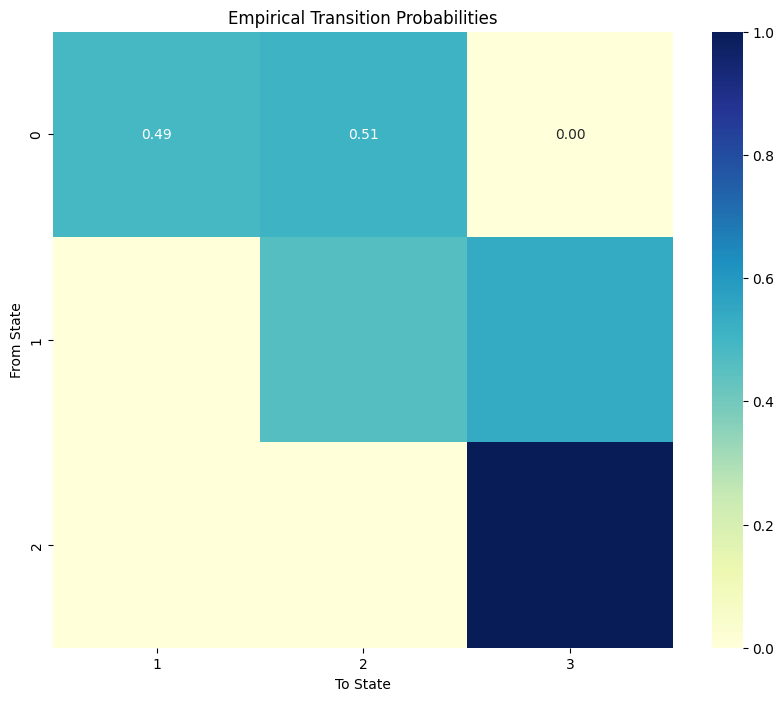

In [5]:
# Examine transition patterns
transition_counts = df.groupby(['from_state', 'to_state']).size().unstack(fill_value=0)
transition_prob = transition_counts.div(transition_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(transition_prob, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Empirical Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

## Train a MultiStateNN Model

Now, let's train a neural network model to predict disease state transitions.

In [6]:
# Define our covariates
covariates = ['age', 'biomarker', 'treatment']
input_dim = len(covariates)
hidden_dims = [64, 32]  # Two hidden layers
num_states = 4

# Create configuration objects for the model and training
model_config = ModelConfig(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    num_states=num_states,
    state_transitions=state_transitions
)

train_config = TrainConfig(
    epochs=50,
    batch_size=64,
    learning_rate=0.001
)

In [7]:
# Fit the model using the configuration-based API
model = fit(
    df=df,
    covariates=covariates,
    model_config=model_config,
    train_config=train_config
)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

## Make Predictions

Now that we have a trained model, let's make some predictions for different patient profiles.

In [8]:
# Create test cases with different profiles
test_cases = [
    # [age, biomarker, treatment]
    [70, 1.5, 0],  # Older patient, high biomarker, no treatment
    [70, 1.5, 1],  # Older patient, high biomarker, with treatment
    [50, 1.5, 0],  # Younger patient, high biomarker, no treatment
    [50, 1.5, 1],  # Younger patient, high biomarker, with treatment
    [70, 0.5, 0],  # Older patient, low biomarker, no treatment
    [70, 0.5, 1],  # Older patient, low biomarker, with treatment
    [50, 0.5, 0],  # Younger patient, low biomarker, no treatment
    [50, 0.5, 1],  # Younger patient, low biomarker, with treatment
]

# Convert to tensor
x_test = torch.tensor(test_cases, dtype=torch.float32)

In [9]:
# Function to print predicted probabilities with labels
def print_transition_probs(x, model, time_idx, from_state):
    probs = model.predict_proba(x, time_idx, from_state).numpy()
    next_states = model.state_transitions[from_state]
    
    # Map state indices to names
    state_names = ['Healthy', 'Mild', 'Moderate', 'Severe']
    state_from = state_names[from_state]
    next_state_names = [state_names[s] for s in next_states]
    
    # Create DataFrame for display
    profiles = [
        f"Age: {x[i,0]:.0f}, Biomarker: {x[i,1]:.1f}, Treatment: {int(x[i,2])}"
        for i in range(len(x))
    ]
    
    result_df = pd.DataFrame(probs, columns=next_state_names, index=profiles)
    print(f"Transition probabilities from {state_from} state (t={time_idx}):")
    return result_df

In [10]:
# Predict transitions from Healthy (State 0) at time 0
healthy_probs = print_transition_probs(x_test, model, time_idx=0, from_state=0)
healthy_probs

Transition probabilities from Healthy state (t=0):


,Mild,Moderate
"Age: 70, Biomarker: 1.5, Treatment: 0",0.501366,0.498634
"Age: 70, Biomarker: 1.5, Treatment: 1",0.501350,0.498650
"Age: 50, Biomarker: 1.5, Treatment: 0",0.501364,0.498636
"Age: 50, Biomarker: 1.5, Treatment: 1",0.501342,0.498658
"Age: 70, Biomarker: 0.5, Treatment: 0",0.501363,0.498637
"Age: 70, Biomarker: 0.5, Treatment: 1",0.501347,0.498653
"Age: 50, Biomarker: 0.5, Treatment: 0",0.501360,0.498640
"Age: 50, Biomarker: 0.5, Treatment: 1",0.501337,0.498663


In [11]:
# Predict transitions from Mild (State 1) at time 0
mild_probs = print_transition_probs(x_test, model, time_idx=0, from_state=1)
mild_probs

Transition probabilities from Mild state (t=0):


,Moderate,Severe
"Age: 70, Biomarker: 1.5, Treatment: 0",0.464940,0.535060
"Age: 70, Biomarker: 1.5, Treatment: 1",0.464918,0.535082
"Age: 50, Biomarker: 1.5, Treatment: 0",0.464917,0.535083
"Age: 50, Biomarker: 1.5, Treatment: 1",0.464885,0.535115
"Age: 70, Biomarker: 0.5, Treatment: 0",0.464965,0.535035
"Age: 70, Biomarker: 0.5, Treatment: 1",0.464943,0.535057
"Age: 50, Biomarker: 0.5, Treatment: 0",0.464951,0.535049
"Age: 50, Biomarker: 0.5, Treatment: 1",0.464920,0.535080


## Visualize Transitions

Let's use the built-in visualization tools to explore the predicted transitions.

<Figure size 1200x800 with 0 Axes>

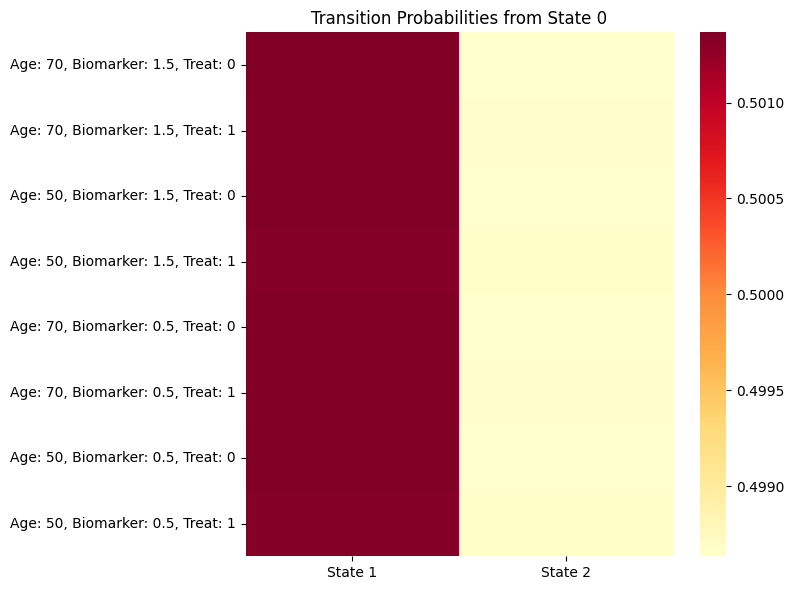

In [12]:
# Visualize transition heatmap for patients from healthy state
plt.figure(figsize=(12, 8))
ax = plot_transition_heatmap(model, x_test, time_idx=0, from_state=0)
# Update y-axis labels with patient profiles
profiles = [
    f"Age: {x_test[i,0]:.0f}, Biomarker: {x_test[i,1]:.1f}, Treat: {int(x_test[i,2])}"
    for i in range(len(x_test))
]
ax.set_yticklabels(profiles)
plt.tight_layout()
plt.show()

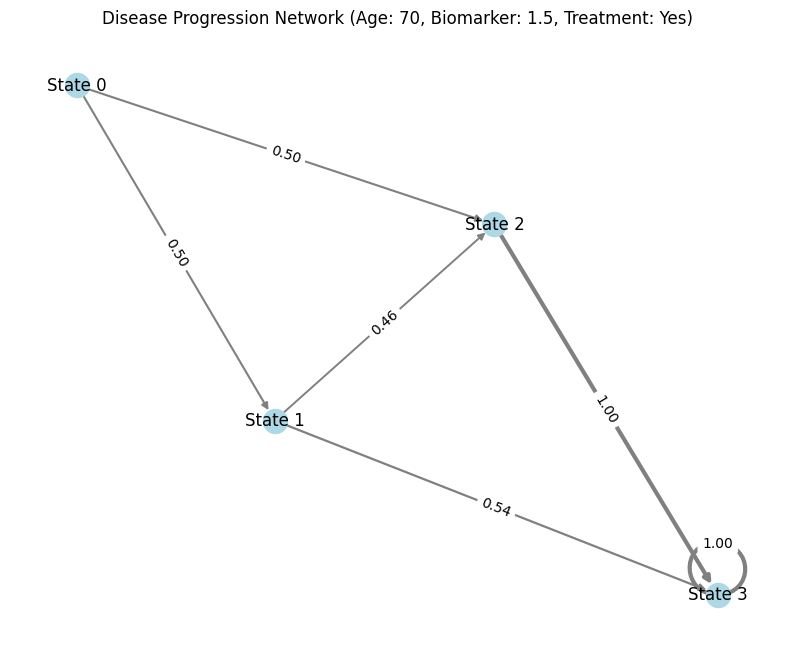

In [13]:
# Visualize the transition graph for a specific patient
# Let's use an older patient with high biomarker and treatment
patient1 = torch.tensor([[70, 1.5, 1]], dtype=torch.float32)
fig, ax = plot_transition_graph(model, patient1, time_idx=0, threshold=0.01)
plt.title("Disease Progression Network (Age: 70, Biomarker: 1.5, Treatment: Yes)")
plt.show()

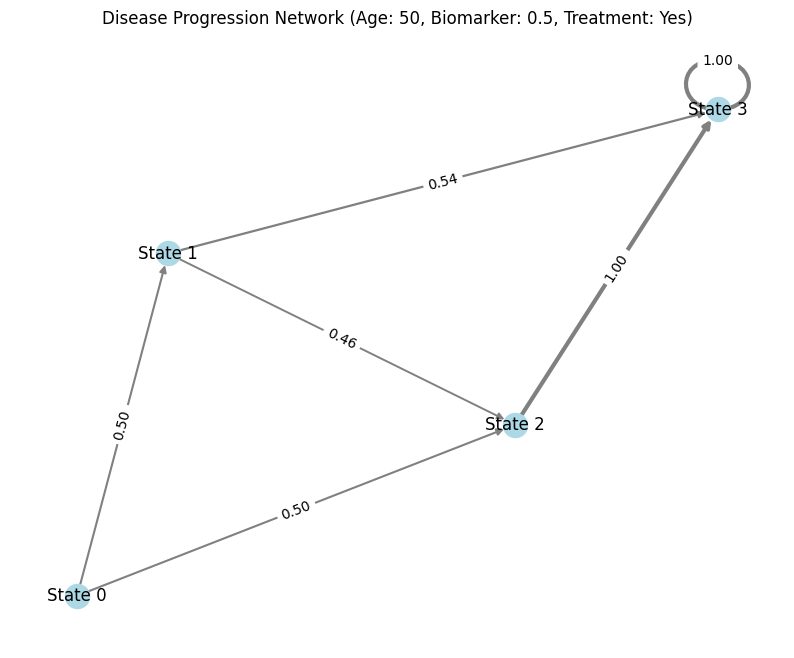

In [14]:
# Compare with a younger patient with low biomarker and treatment
patient2 = torch.tensor([[50, 0.5, 1]], dtype=torch.float32)
fig, ax = plot_transition_graph(model, patient2, time_idx=0, threshold=0.01)
plt.title("Disease Progression Network (Age: 50, Biomarker: 0.5, Treatment: Yes)")
plt.show()

## Understand Feature Importance

Let's examine how each feature affects the transition probabilities by varying one feature while keeping others constant.

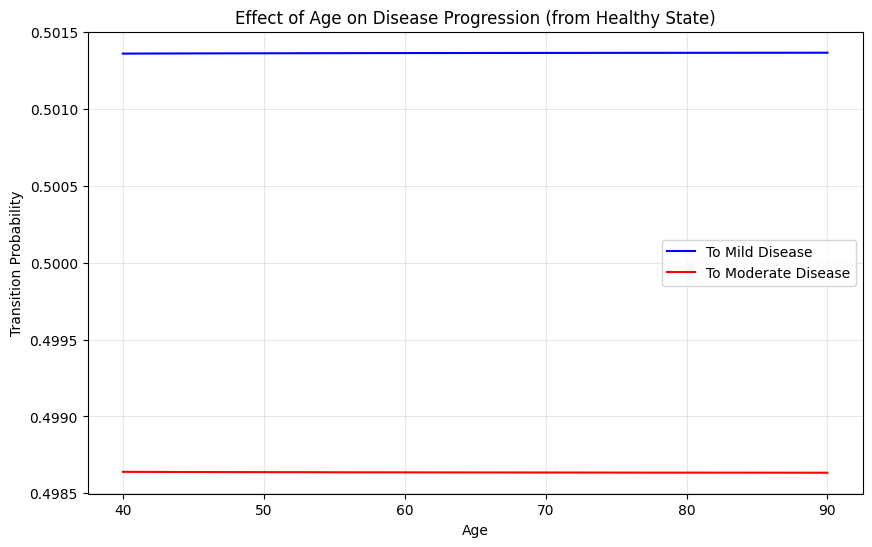

In [15]:
# Generate age range (40 to 90)
ages = torch.linspace(40, 90, 20)
# Keep biomarker and treatment constant
biomarker = torch.ones_like(ages) * 1.0
treatment = torch.zeros_like(ages)  # No treatment

# Stack to create input tensor
age_inputs = torch.stack([ages, biomarker, treatment], dim=1)

# Get transition probabilities from healthy
age_probs = model.predict_proba(age_inputs, time_idx=0, from_state=0).detach()

# Plot the impact of age on transitions from healthy state
plt.figure(figsize=(10, 6))
plt.plot(ages.numpy(), age_probs[:, 0].numpy(), 'b-', label='To Mild Disease')
plt.plot(ages.numpy(), age_probs[:, 1].numpy(), 'r-', label='To Moderate Disease')
plt.xlabel('Age')
plt.ylabel('Transition Probability')
plt.title('Effect of Age on Disease Progression (from Healthy State)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

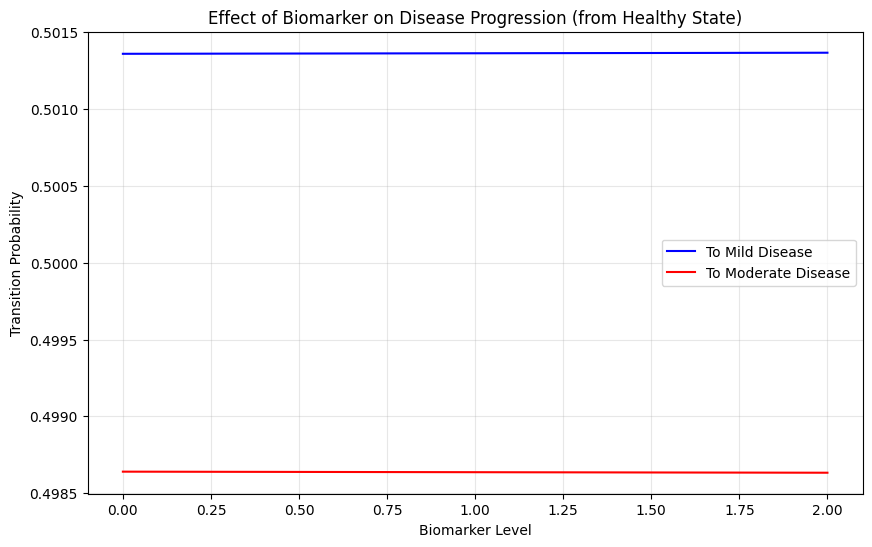

In [16]:
# Generate biomarker range (0 to 2)
biomarkers = torch.linspace(0, 2, 20)
# Keep age and treatment constant
age = torch.ones_like(biomarkers) * 65  # Average age
treatment = torch.zeros_like(biomarkers)  # No treatment

# Stack to create input tensor
biomarker_inputs = torch.stack([age, biomarkers, treatment], dim=1)

# Get transition probabilities from healthy
biomarker_probs = model.predict_proba(biomarker_inputs, time_idx=0, from_state=0).detach()

# Plot the impact of biomarker on transitions from healthy state
plt.figure(figsize=(10, 6))
plt.plot(biomarkers.numpy(), biomarker_probs[:, 0].numpy(), 'b-', label='To Mild Disease')
plt.plot(biomarkers.numpy(), biomarker_probs[:, 1].numpy(), 'r-', label='To Moderate Disease')
plt.xlabel('Biomarker Level')
plt.ylabel('Transition Probability')
plt.title('Effect of Biomarker on Disease Progression (from Healthy State)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Compare Treatment Effects

Let's examine how treatment affects the disease progression by comparing treated vs. untreated patients across different profiles.

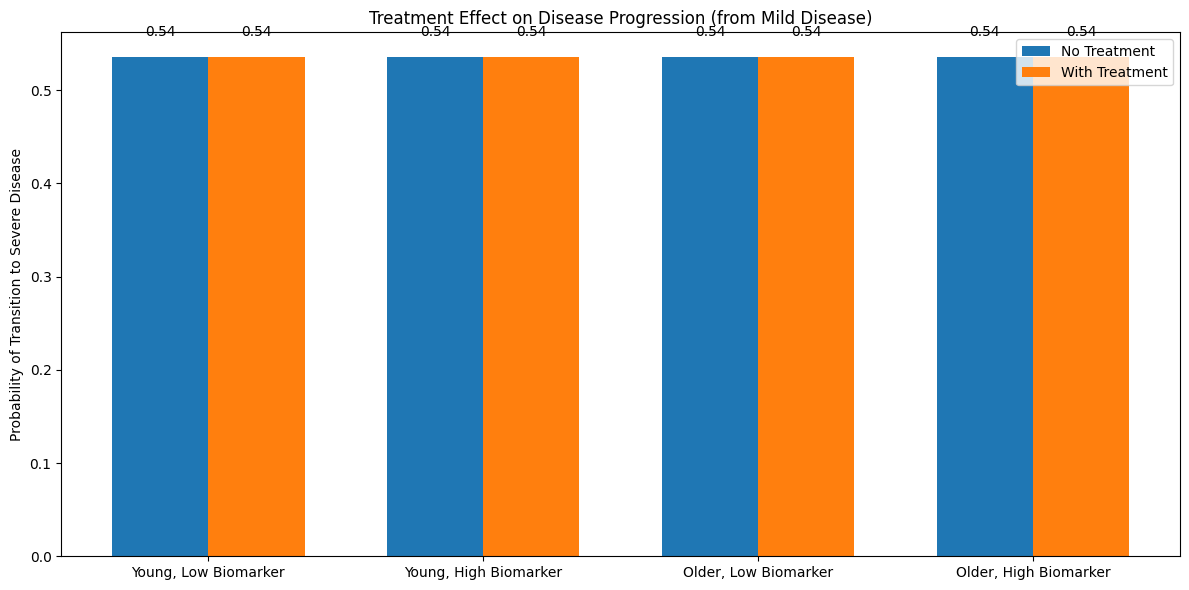

In [17]:
# Create a set of profiles with and without treatment
profiles_base = [
    [50, 0.5],  # Young, low biomarker
    [50, 1.5],  # Young, high biomarker
    [70, 0.5],  # Older, low biomarker
    [70, 1.5],  # Older, high biomarker
]

# Create with/without treatment profiles
profiles_no_treatment = [p + [0] for p in profiles_base]
profiles_with_treatment = [p + [1] for p in profiles_base]

# Convert to tensors
x_no_treatment = torch.tensor(profiles_no_treatment, dtype=torch.float32)
x_with_treatment = torch.tensor(profiles_with_treatment, dtype=torch.float32)

# Get predictions for mild to severe transitions
probs_no_treatment = model.predict_proba(x_no_treatment, time_idx=0, from_state=1)
probs_with_treatment = model.predict_proba(x_with_treatment, time_idx=0, from_state=1)

# Extract probabilities for transition to severe state (index 1 in the output)
severe_probs_no_treatment = probs_no_treatment[:, 1].detach().numpy()
severe_probs_with_treatment = probs_with_treatment[:, 1].detach().numpy()

# Create labels for the profiles
profile_labels = [
    "Young, Low Biomarker",
    "Young, High Biomarker",
    "Older, Low Biomarker",
    "Older, High Biomarker",
]

# Plot the comparison
width = 0.35
x = np.arange(len(profile_labels))

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, severe_probs_no_treatment, width, label='No Treatment')
bars2 = ax.bar(x + width/2, severe_probs_with_treatment, width, label='With Treatment')

ax.set_ylabel('Probability of Transition to Severe Disease')
ax.set_title('Treatment Effect on Disease Progression (from Mild Disease)')
ax.set_xticks(x)
ax.set_xticklabels(profile_labels)
ax.legend()

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

fig.tight_layout()
plt.show()

## Conclusions

In this notebook, we've demonstrated how to use MultiStateNN to model disease progression through multiple states. We've shown how to:

1. Prepare data for training
2. Train a multistate neural network model
3. Make predictions for different patient profiles
4. Visualize the transition probabilities and state network
5. Analyze the effects of covariates on disease progression
6. Compare treatment effectiveness across different patient profiles

This approach can be extended to real-world datasets with more complex state transition structures and additional covariates.